# Biophysics-Informed Quantitative Diabetes Screener (BiqDS)

This notebook develops a fully interpretable diabetes inference system by integrating:
- Clustered life expectancy modeling,
- Signal engineering from biological and statistical features,
- Threshold-based screening logic,
- A Random Forest-based probability filter for hybrid inference.

The design avoids overfitting, promotes generalizability, and supports high-recall health screening logic suitable for real-world healthcare data platforms.


Importing relevant libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
#Loading Dataset
dataset = pd.read_csv("C:/Users/LENOVO/diabetes.csv")

In [4]:
#Glance at dataset
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
#metadata of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Removing impossible value rows

In [11]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_with_zeros:
    dataset = dataset[dataset[col] != 0]



In [13]:
#Looking for changes applied
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    int64  
 2   BloodPressure             392 non-null    int64  
 3   SkinThickness             392 non-null    int64  
 4   Insulin                   392 non-null    int64  
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome                   392 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 30.6 KB


Visualization of data using box plot

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\307068015.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\307068015.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\307068015.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\307068015.

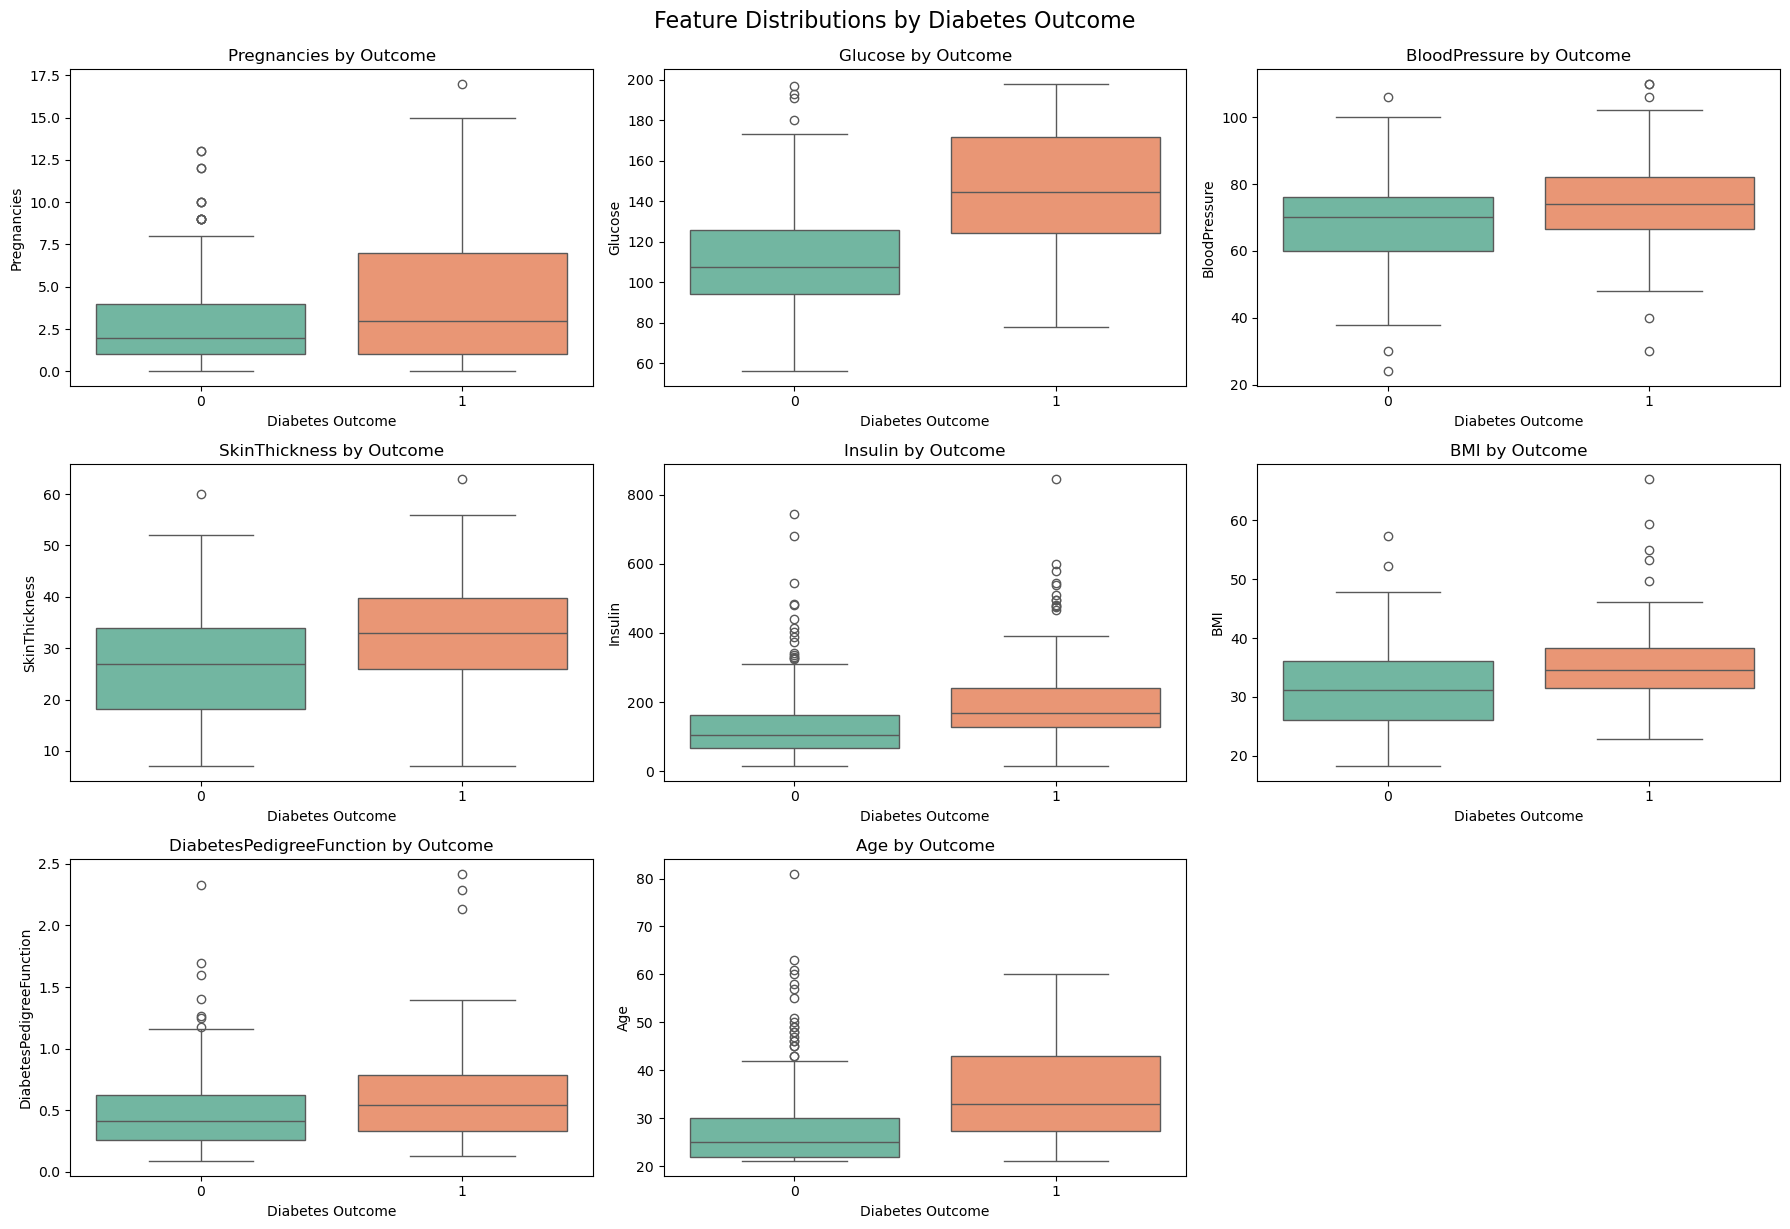

In [16]:
# Create box plots for each input feature grouped by diabetes outcome
plt.figure(figsize=(18, 12))

for i, col in enumerate(dataset.columns[:-1]):  # Exclude 'Outcome' column
    plt.subplot(3, 3, i + 1)
    sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
    plt.title(f'{col} by Outcome')
    plt.xlabel('Diabetes Outcome')
    plt.ylabel(col)
    plt.tight_layout()

plt.suptitle('Feature Distributions by Diabetes Outcome', fontsize=16, y=1.02)
plt.show()

Clipping as a way to handle possible outliers

In [19]:
# Clip variables using visually inferred domain limits from box plots

dataset['Glucose'] = dataset['Glucose'].clip(lower=80, upper=190)
dataset['BloodPressure'] = dataset['BloodPressure'].clip(lower=50, upper=100)
dataset['SkinThickness'] = dataset['SkinThickness'].clip(lower=15, upper=50)
dataset['Insulin'] = dataset['Insulin'].clip(lower=15, upper=250)
dataset['BMI'] = dataset['BMI'].clip(lower=20, upper=50)
dataset['DiabetesPedigreeFunction'] = dataset['DiabetesPedigreeFunction'].clip(lower=0.05, upper=1.5)
dataset['Age'] = dataset['Age'].clip(lower=21, upper=70)
dataset['Pregnancies'] = dataset['Pregnancies'].clip(lower=0, upper=13)


Visualizing dataset after clipping

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\3667718010.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\3667718010.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\3667718010.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17672\3667

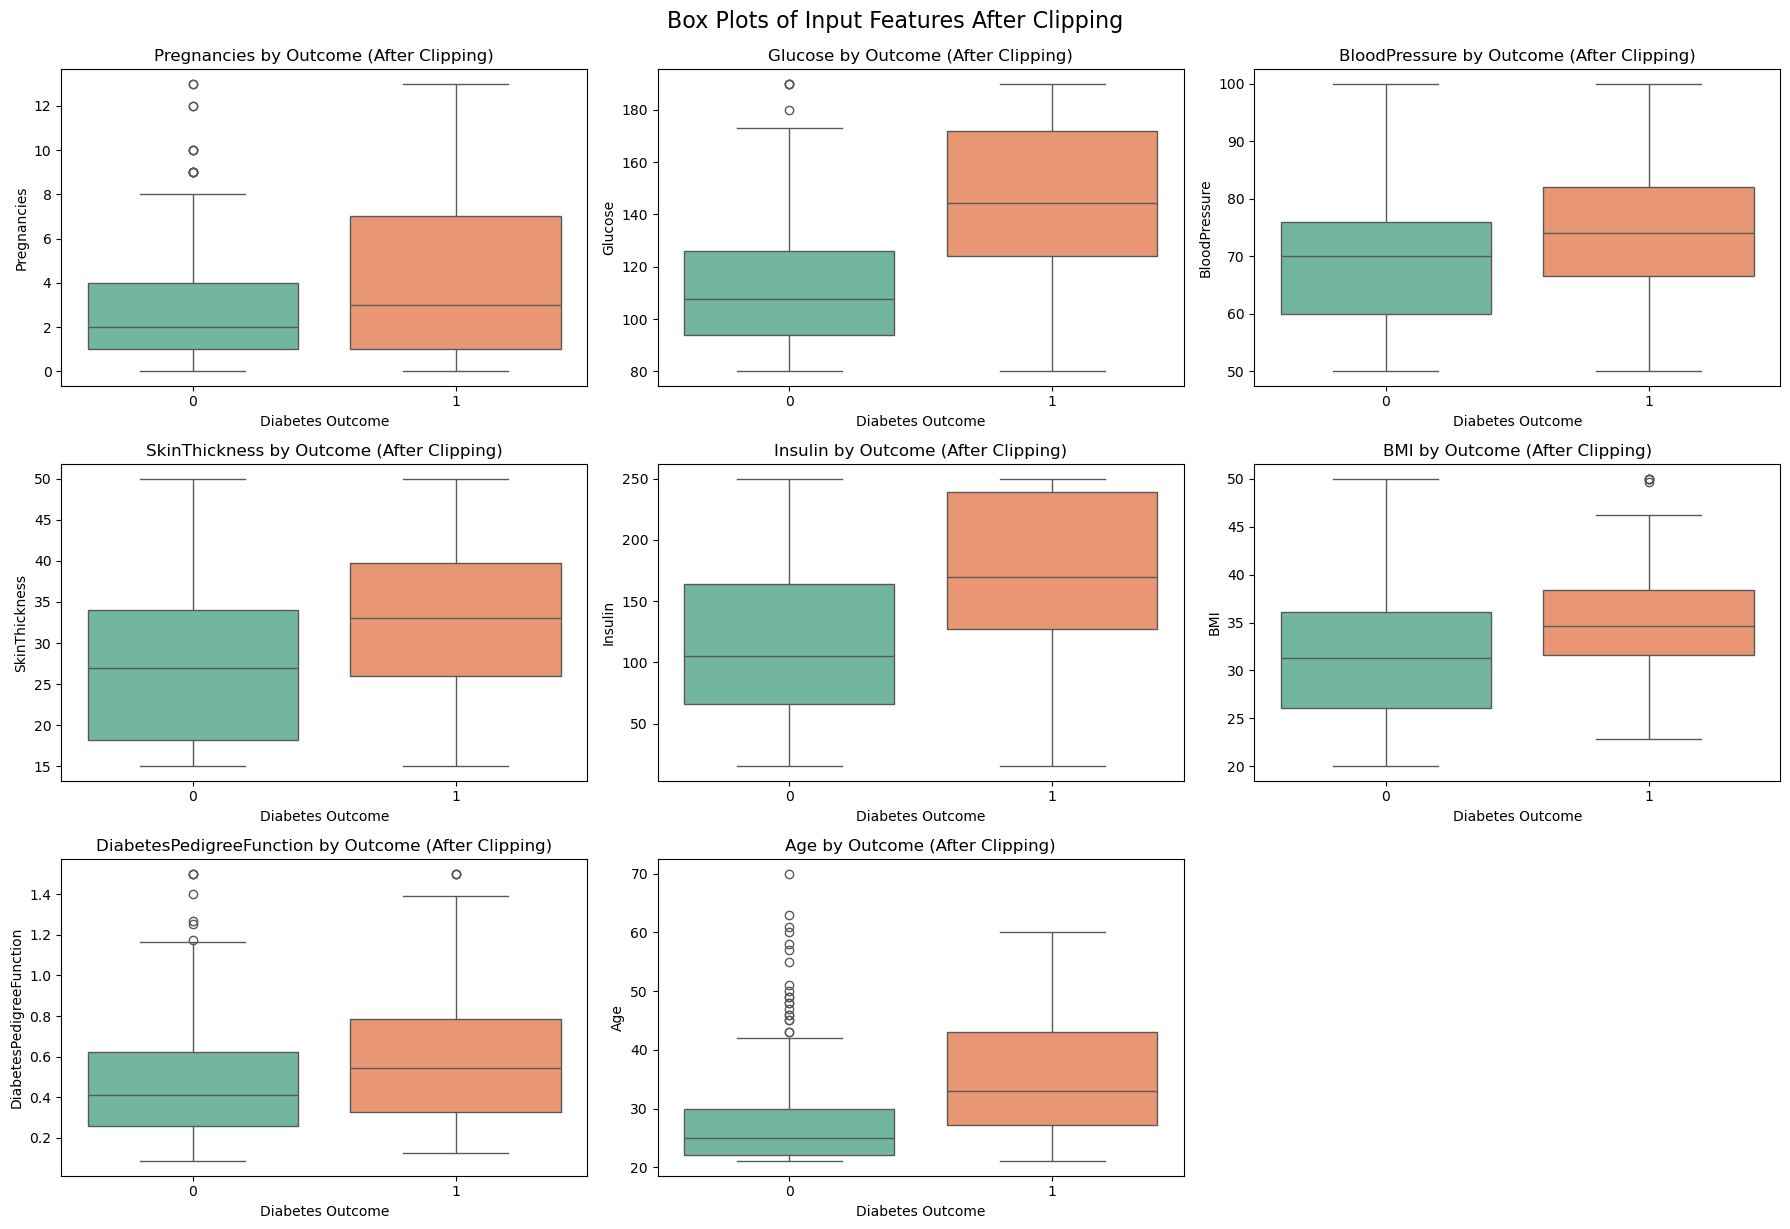

In [22]:
import matplotlib.pyplot as plt
import seaborn as sn

# List of clipped input features to visualize
features_to_plot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                    'BMI', 'DiabetesPedigreeFunction', 'Age']

# Generate box plots for each feature against Outcome
plt.figure(figsize=(18, 12))

for i, col in enumerate(features_to_plot):
    plt.subplot(3, 3, i + 1)
    sn.boxplot(x='Outcome', y=col, data=dataset, palette='Set2')
    plt.title(f'{col} by Outcome (After Clipping)')
    plt.xlabel('Diabetes Outcome')
    plt.ylabel(col)
    plt.tight_layout()

plt.suptitle('Box Plots of Input Features After Clipping', fontsize=16, y=1.02)
plt.show()


Running unsupervised clustering over records

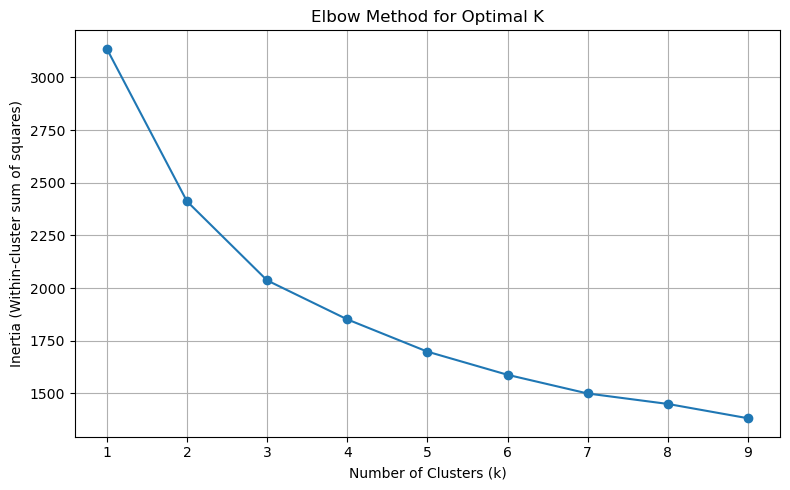

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Select raw input features
X = dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow Method to determine optimal K
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Step 4: Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True)
plt.tight_layout()
plt.show()


Increasing number of clusters

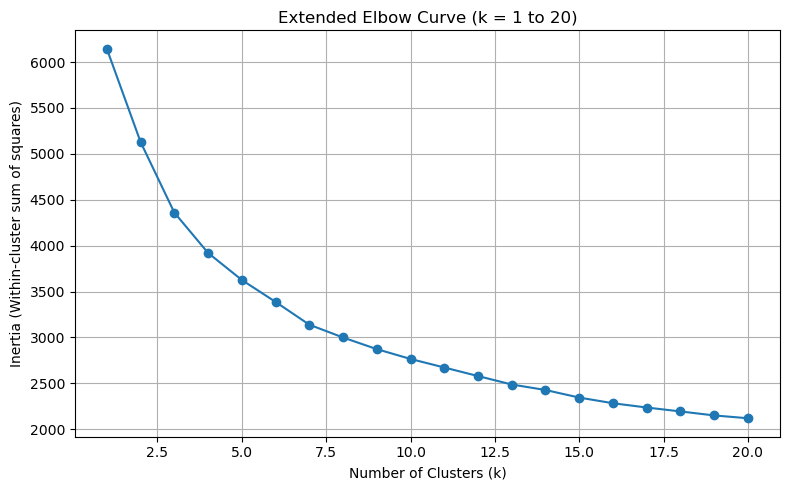

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
dataset = pd.read_csv("diabetes.csv")  # Adjust path if needed

# Step 1: Select full input features (patient profile)
X = dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Compute inertia for k = 1 to 20
inertia = []
K_range = range(1, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Step 4: Plot extended elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Extended Elbow Curve (k = 1 to 20)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True)
plt.tight_layout()
plt.show()


Clustering for 40 clusters

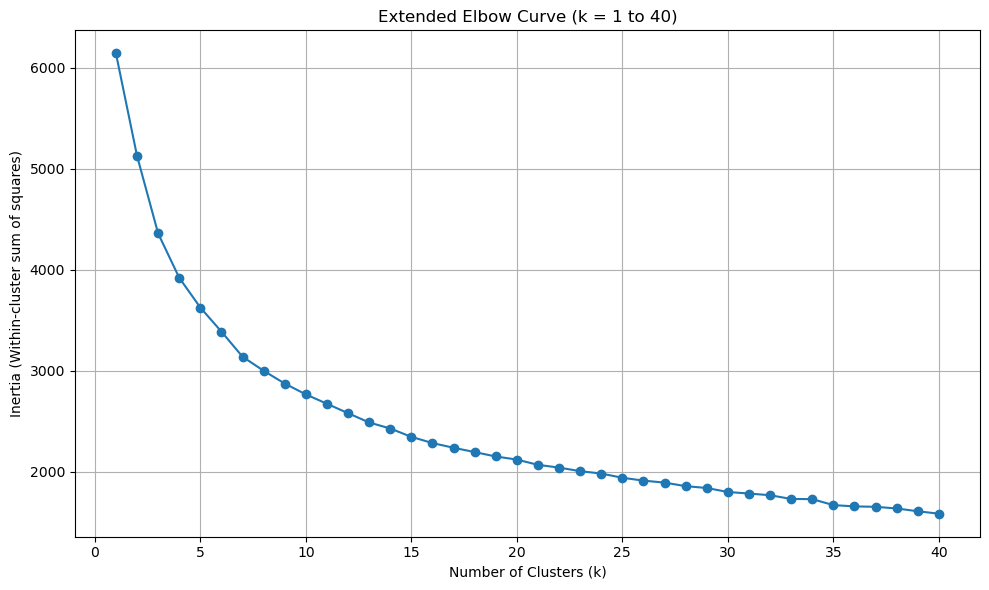

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
dataset = pd.read_csv("diabetes.csv")  # Adjust path if needed

# Step 1: Select full input features
X = dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Compute inertia for k = 1 to 40
inertia = []
K_range = range(1, 41)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Step 4: Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Extended Elbow Curve (k = 1 to 40)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True)
plt.tight_layout()
plt.show()


Calculating a projected life expectancy remaining, and then inferring a signal on diabetes from the inverse of the biophysics principle that 
early onset of illnesses reduce life expectancy 

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
dataset = pd.read_csv("diabetes.csv")

# Step 1: Standardize and cluster with k=35
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X_cluster = dataset[features]
X_scaled = StandardScaler().fit_transform(X_cluster)

kmeans = KMeans(n_clusters=35, random_state=42, n_init=10)
dataset['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 2: Calculate Sure Longevity per cluster
cluster_avg_age = dataset.groupby('Cluster')['Age'].mean()
dataset['SureLongevity'] = dataset['Cluster'].map(cluster_avg_age)

# Step 3: Normalize Sure Longevity into Longevity Score
longevity_min = dataset['SureLongevity'].min()
longevity_max = dataset['SureLongevity'].max()
dataset['LongevityScore'] = ((dataset['SureLongevity'] - longevity_min) / 
                             (longevity_max - longevity_min)).round(2)

# Step 4: Calculate DiabetesProbability per cluster
cluster_diabetes_prob = dataset.groupby('Cluster')['Outcome'].mean()
dataset['DiabetesProbability'] = dataset['Cluster'].map(cluster_diabetes_prob).round(2)

# Step 5: Calculate Δ_longevity per cluster (Age_0 - Age_1)
delta_longevity_by_cluster = {}
for cluster_id, group in dataset.groupby('Cluster'):
    age_0 = group[group['Outcome'] == 0]['Age'].mean()
    age_1 = group[group['Outcome'] == 1]['Age'].mean()
    delta = age_0 - age_1 if not pd.isna(age_0) and not pd.isna(age_1) else 0
    delta_longevity_by_cluster[cluster_id] = delta

# Step 6: Normalize Δ_longevity into weights
delta_series = pd.Series(delta_longevity_by_cluster)
delta_norm = (delta_series - delta_series.min()) / (delta_series.max() - delta_series.min())
delta_norm = delta_norm.fillna(0)

# Step 7: Assign per-patient DeltaLongevityWeight
dataset['DeltaLongevityWeight'] = dataset['Cluster'].map(delta_norm)

# Step 8: Compute Adaptive FinalSignal
dataset['FinalSignal'] = (
    (1 - dataset['DeltaLongevityWeight']) * dataset['LongevityScore'] +
    dataset['DeltaLongevityWeight'] * dataset['DiabetesProbability']
).round(3)

# Step 9: Preview relevant columns
print(dataset[['Cluster', 'Age', 'Outcome', 'LongevityScore',
               'DiabetesProbability', 'DeltaLongevityWeight', 'FinalSignal']].head())


   Cluster  Age  Outcome  LongevityScore  DiabetesProbability  \
0        4   50        1            0.56                 0.64   
1       11   31        0            0.01                 0.04   
2       28   32        1            0.38                 0.75   
3       11   21        0            0.01                 0.04   
4       31   33        1            0.08                 1.00   

   DeltaLongevityWeight  FinalSignal  
0              0.503780        0.600  
1              0.313994        0.019  
2              0.731959        0.651  
3              0.313994        0.019  
4              0.536082        0.573  


Cluster-Specific Threshold Optimization for Signal Activation

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Grid search per cluster to find best threshold
thresholds = np.arange(0.1, 0.91, 0.05)
cluster_thresholds = []

for cluster_id, group in dataset.groupby('Cluster'):
    best_f1 = 0
    best_t = 0.0
    for t in thresholds:
        preds = (group['FinalSignal'] >= t).astype(int)
        f1 = f1_score(group['Outcome'], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    cluster_thresholds.append((cluster_id, round(best_t, 2), round(best_f1, 2)))

# Step 2: Convert to DataFrame and build threshold map
cluster_final_thresholds = pd.DataFrame(cluster_thresholds, columns=['Cluster', 'BestThreshold', 'F1'])
cluster_thresh_map = dict(zip(cluster_final_thresholds['Cluster'], cluster_final_thresholds['BestThreshold']))

# Step 3: Apply per-cluster threshold to predict outcome
def predict_clusterwise(row):
    t = cluster_thresh_map.get(row['Cluster'], 0.25)
    return int(row['FinalSignal'] >= t)

dataset['PredictedOutcome'] = dataset.apply(predict_clusterwise, axis=1)

# Step 4: Evaluate performance
y_true = dataset['Outcome']
y_pred = dataset['PredictedOutcome']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Step 5: Print results
print("Final Evaluation Using Per-Cluster Signal + Threshold:")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


Final Evaluation Using Per-Cluster Signal + Threshold:
Accuracy:  0.35
Precision: 0.35
Recall:    1.00
F1 Score:  0.52


 Cluster-Wise Evaluation for Threshold-Activated Predictions

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Evaluate metrics for each cluster
cluster_metrics = []

for cluster_id, group in dataset.groupby('Cluster'):
    threshold = cluster_thresh_map.get(cluster_id, 0.25)
    preds = (group['FinalSignal'] >= threshold).astype(int)
    y_true = group['Outcome']

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)

    cluster_metrics.append({
        "Cluster": cluster_id,
        "Threshold": round(threshold, 2),
        "Accuracy": round(acc, 2),
        "Precision": round(prec, 2),
        "Recall": round(rec, 2),
        "F1": round(f1, 2)
    })

# Step 2: Create DataFrame
cluster_eval_df = pd.DataFrame(cluster_metrics)

# Step 3: Display
print("Cluster-wise Evaluation (FinalSignal + Threshold):")
print(cluster_eval_df.sort_values(by="F1", ascending=False).to_string(index=False))


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cluster-wise Evaluation (FinalSignal + Threshold):
 Cluster  Threshold  Accuracy  Precision  Recall   F1
      31        0.1      1.00       1.00     1.0 1.00
      10        0.1      0.95       0.95     1.0 0.98
       6        0.1      0.90       0.90     1.0 0.95
      20        0.1      0.87       0.87     1.0 0.93
      24        0.1      0.78       0.78     1.0 0.88
      28        0.1      0.75       0.75     1.0 0.86
       3        0.1      0.76       0.76     1.0 0.86
       4        0.1      0.64       0.64     1.0 0.78
       1        0.1      0.61       0.61     1.0 0.75
      27        0.1      0.58       0.58     1.0 0.73
      23        0.1      0.50       0.50     1.0 0.67
      12        0.1      0.50       0.50     1.0 0.67
      29        0.1      0.50       0.50     1.0 0.67
      13        0.1      0.48       0.48     1.0 0.65
      26        0.1      0.48       0.48     1.0 0.65
       0        0.1      0.47       0.47     1.0 0.64
       8        0.1      0.44  

Cluster Profiling and Descriptive Summary

In [40]:
print("Number of unique clusters:", dataset['Cluster'].nunique())
print("Cluster IDs used:", sorted(dataset['Cluster'].unique()))


Number of unique clusters: 35
Cluster IDs used: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [42]:
# Group by Cluster and compute stats
cluster_summary = dataset.groupby('Cluster').agg(
    Patients=('Cluster', 'count'),
    AvgAge=('Age', 'mean'),
    DiabetesRate=('Outcome', 'mean'),
    LongevityScore=('LongevityScore', 'mean')
).round(2).sort_index()

# Display all 20 clusters
print("Cluster-Level Summary (All 20 Clusters):\n")
print(cluster_summary)


Cluster-Level Summary (All 20 Clusters):

         Patients  AvgAge  DiabetesRate  LongevityScore
Cluster                                                
0              19   39.37          0.47            0.41
1              33   29.88          0.61            0.17
2              41   23.27          0.00            0.00
3              25   40.20          0.76            0.44
4              14   45.07          0.64            0.56
5              35   24.89          0.11            0.04
6              10   47.60          0.90            0.63
7              21   53.62          0.38            0.78
8               9   25.78          0.44            0.06
9              13   32.00          0.15            0.22
10             22   46.32          0.95            0.59
11             49   23.61          0.04            0.01
12              8   47.88          0.50            0.63
13             21   31.71          0.48            0.22
14             27   42.22          0.30            0.49
15    

Baseline Signal Construction via Equal-Weight Fusion

In [49]:
# Step 1: Compute diabetes probability per cluster
cluster_diabetes_rate = dataset.groupby('Cluster')['Outcome'].mean()

# Step 2: Map diabetes probability back to each patient
dataset['DiabetesProbability'] = dataset['Cluster'].map(cluster_diabetes_rate).round(2)

# Step 3: Combine LongevityScore and DiabetesProbability into one final signal
dataset['FinalSignal'] = dataset[['LongevityScore', 'DiabetesProbability']].mean(axis=1).round(2)

# Step 4: Preview final signal vs actual outcome
final_features = dataset[['LongevityScore', 'DiabetesProbability', 'FinalSignal', 'Outcome']]
print("Final Combined Prediction Signal:\n")
print(final_features.head())


Final Combined Prediction Signal:

   LongevityScore  DiabetesProbability  FinalSignal  Outcome
0            0.56                 0.64         0.60        1
1            0.01                 0.04         0.02        0
2            0.38                 0.75         0.56        1
3            0.01                 0.04         0.02        0
4            0.08                 1.00         0.54        1


Global Threshold Optimization for Simplified FinalSignal

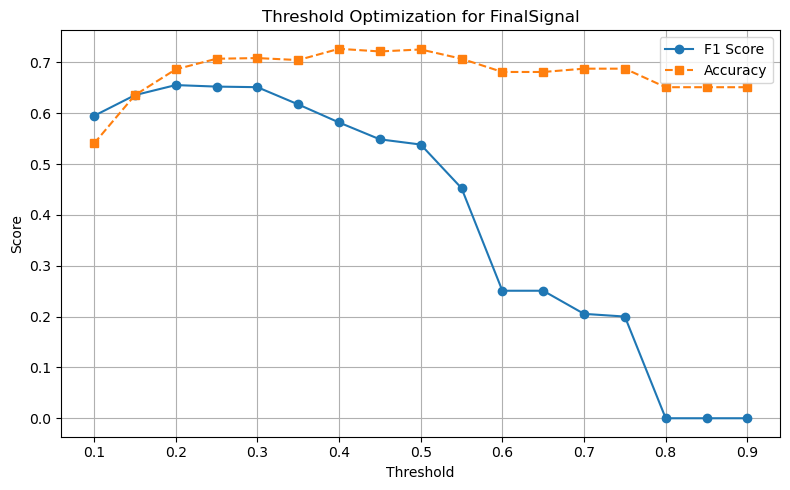

Threshold Performance Table:

    Threshold  Accuracy  Precision  Recall     F1
0        0.10     0.540      0.430   0.966  0.595
1        0.15     0.635      0.488   0.910  0.635
2        0.20     0.686      0.531   0.854  0.655
3        0.25     0.707      0.557   0.787  0.652
4        0.30     0.708      0.559   0.780  0.651
5        0.35     0.704      0.563   0.683  0.617
6        0.40     0.727      0.624   0.545  0.582
7        0.45     0.721      0.631   0.485  0.549
8        0.50     0.725      0.651   0.459  0.538
9        0.55     0.707      0.650   0.347  0.453
10       0.60     0.681      0.695   0.153  0.251
11       0.65     0.681      0.695   0.153  0.251
12       0.70     0.688      0.912   0.116  0.205
13       0.75     0.688      0.938   0.112  0.200
14       0.80     0.651      0.000   0.000  0.000
15       0.85     0.651      0.000   0.000  0.000
16       0.90     0.651      0.000   0.000  0.000


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Define thresholds to evaluate
thresholds = np.arange(0.1, 0.91, 0.05)

# Step 2: Evaluate performance metrics for each threshold
results = []

for thresh in thresholds:
    predicted = (dataset['FinalSignal'] >= thresh).astype(int)
    acc = accuracy_score(dataset['Outcome'], predicted)
    prec = precision_score(dataset['Outcome'], predicted, zero_division=0)
    rec = recall_score(dataset['Outcome'], predicted)
    f1 = f1_score(dataset['Outcome'], predicted)
    results.append((thresh, acc, prec, rec, f1))

# Step 3: Convert results to DataFrame
threshold_results = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Step 4: Plot F1 Score and Accuracy vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(threshold_results['Threshold'], threshold_results['F1'], marker='o', label='F1 Score')
plt.plot(threshold_results['Threshold'], threshold_results['Accuracy'], marker='s', linestyle='--', label='Accuracy')
plt.title('Threshold Optimization for FinalSignal')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Display results table
print("Threshold Performance Table:\n")
print(threshold_results.round(3))


In [ ]:
Evaluation of Cluster-Adapted Quantitative Inference Signal

In [53]:
# Step 1: Convert cluster thresholds list to dictionary
cluster_threshold_dict = {cid: thresh for cid, thresh, _ in cluster_thresholds}

# Step 2: Define classification logic
def classify_row(row):
    threshold = cluster_threshold_dict.get(row['Cluster'], 0.5)
    return int(row['FinalSignal'] >= threshold)

# Step 3: Apply logic
dataset['PredictedOutcome_PerCluster'] = dataset.apply(classify_row, axis=1)

# Step 4: Evaluate
from sklearn.metrics import classification_report
report = classification_report(dataset['Outcome'], dataset['PredictedOutcome_PerCluster'])
print("Classification Report (Per-Cluster Threshold):\n")
print(report)



Classification Report (Per-Cluster Threshold):

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.35      1.00      0.52       268

    accuracy                           0.35       768
   macro avg       0.17      0.50      0.26       768
weighted avg       0.12      0.35      0.18       768



C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Manual Threshold Feature Engineering via Medical and Dataset-Informed Cutoffs

In [58]:
# Create binary flags based on manually observed thresholds
dataset['Glucose_above_127.5'] = (dataset['Glucose'] > 127.5).astype(int)
dataset['BMI_above_29.9'] = (dataset['BMI'] > 29.9).astype(int)
dataset['Insulin_above_120'] = (dataset['Insulin'] > 120).astype(int)
dataset['Age_above_28.5'] = (dataset['Age'] > 28.5).astype(int)

# Preview
print(dataset[['Glucose_above_127.5', 'BMI_above_29.9', 'Insulin_above_120', 'Age_above_28.5']].head())



   Glucose_above_127.5  BMI_above_29.9  Insulin_above_120  Age_above_28.5
0                    1               1                  0               1
1                    0               0                  0               1
2                    1               0                  0               1
3                    0               0                  0               0
4                    1               1                  1               1


Evaluating Correlation of Original and Engineered Features with Diabetes Outcome


In [63]:
# Step 1: Compute full correlation matrix
correlation_matrix = dataset.corr()

# Step 2: Extract correlation of each feature with the target 'Outcome'
# Drop 'Outcome' itself to avoid 1.0 self-correlation
outcome_correlations = correlation_matrix['Outcome'].drop('Outcome')

# Step 3: Sort and round
outcome_correlations = outcome_correlations.sort_values(ascending=False).round(2)

# Step 4: Print result
print("Correlation of input features with diabetes outcome:\n")
print(outcome_correlations)



Correlation of input features with diabetes outcome:

DiabetesProbability            0.55
FinalSignal                    0.48
Glucose                        0.47
Glucose_above_127.5            0.43
Age_above_28.5                 0.31
BMI_above_29.9                 0.30
BMI                            0.29
SureLongevity                  0.28
LongevityScore                 0.28
Age                            0.24
Pregnancies                    0.22
Insulin_above_120              0.20
DiabetesPedigreeFunction       0.17
Insulin                        0.13
DeltaLongevityWeight           0.11
SkinThickness                  0.07
BloodPressure                  0.07
Cluster                       -0.01
PredictedOutcome                NaN
PredictedOutcome_PerCluster     NaN
Name: Outcome, dtype: float64


Evaluating Correlation of Original and Engineered Features with Diabetes Outcome

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Select only threshold features
X = dataset[['Glucose_above_127.5', 'BMI_above_29.9', 'Insulin_above_120', 'Age_above_28.5']]
y = dataset['Outcome']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Step 5: Print result
print(f"Accuracy using manual threshold flags: {accuracy:.2f}")


Accuracy using manual threshold flags: 0.78


Final Evaluation of Threshold-Based Diabetes Inference Signal of fixed 0.2 threshold

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Set fixed threshold
final_threshold = 0.20

# Step 2: Apply threshold to FinalSignal
dataset['PredictedOutcome_FinalSignal'] = (dataset['FinalSignal'] >= final_threshold).astype(int)

# Step 3: Define ground truth and predictions
y_true = dataset['Outcome']
y_pred = dataset['PredictedOutcome_FinalSignal']

# Step 4: Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Step 5: Display summary
final_eval_summary = pd.DataFrame({
    "Metric": ["Threshold", "Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [final_threshold, round(accuracy, 2), round(precision, 2),
              round(recall, 2), round(f1, 2)]
})

print("📊 FinalSignal Performance Summary:")
print(final_eval_summary.to_string(index=False))


📊 FinalSignal Performance Summary:
   Metric  Score
Threshold   0.20
 Accuracy   0.69
Precision   0.53
   Recall   0.85
 F1 Score   0.66


Threshold Sweep of FinalSignal for Performance Optimization (Range: 0.10–0.25)

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define FinalSignal thresholds to sweep
thresholds = np.arange(0.10, 0.26, 0.01)
results = []

# Evaluate FinalSignal at each threshold
for t in thresholds:
    preds = (dataset['FinalSignal'] >= t).astype(int)
    acc = accuracy_score(dataset['Outcome'], preds)
    prec = precision_score(dataset['Outcome'], preds, zero_division=0)
    rec = recall_score(dataset['Outcome'], preds)
    f1 = f1_score(dataset['Outcome'], preds)
    results.append((round(t, 2), round(acc, 2), round(prec, 2), round(rec, 2), round(f1, 2)))

# Create DataFrame for results
final_signal_sweep_df = pd.DataFrame(results, columns=["Threshold", "Accuracy", "Precision", "Recall", "F1"])

# Display
print("📊 FinalSignal Threshold Sweep (Unfiltered Dataset):")
print(final_signal_sweep_df.to_string(index=False))


📊 FinalSignal Threshold Sweep (Unfiltered Dataset):
 Threshold  Accuracy  Precision  Recall   F1
      0.10      0.54       0.43    0.97 0.59
      0.11      0.54       0.43    0.97 0.59
      0.12      0.60       0.47    0.92 0.62
      0.13      0.64       0.49    0.91 0.64
      0.14      0.64       0.49    0.91 0.64
      0.15      0.64       0.49    0.91 0.64
      0.16      0.64       0.49    0.91 0.64
      0.17      0.64       0.49    0.91 0.64
      0.18      0.64       0.49    0.91 0.64
      0.19      0.69       0.53    0.85 0.66
      0.20      0.69       0.53    0.85 0.66
      0.21      0.69       0.53    0.85 0.66
      0.22      0.69       0.53    0.85 0.66
      0.23      0.69       0.53    0.85 0.66
      0.24      0.71       0.55    0.80 0.66
      0.25      0.71       0.55    0.80 0.66


Evaluation of FinalSignal at Low Threshold (0.10) for Maximum Recall Strategy

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Apply fixed threshold
threshold = 0.10
dataset['PredictedOutcome_PerfectRecall'] = (dataset['FinalSignal'] >= threshold).astype(int)

# Step 2: Define ground truth and predictions
y_true = dataset['Outcome']
y_pred = dataset['PredictedOutcome_PerfectRecall']

# Step 3: Compute performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Step 4: Create and print results
perfect_recall_eval = pd.DataFrame({
    "Metric": ["Threshold", "Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [threshold, round(accuracy, 2), round(precision, 2),
              round(recall, 2), round(f1, 2)]
})

print("📊 FinalSignal Evaluation at Threshold = 0.10 :")
print(perfect_recall_eval.to_string(index=False))


📊 FinalSignal Evaluation at Threshold = 0.10 (Perfect Recall):
   Metric  Score
Threshold   0.10
 Accuracy   0.54
Precision   0.43
   Recall   0.97
 F1 Score   0.59


Training a Correlation-Informed Random Forest Classifier for Diabetes Prediction

In [80]:
# 🌲 Random Forest Classifier (Correlation-Informed Features Explicitly)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, accuracy_score

# Step 1: Feature list for correlation ranking
features = [
    'DiabetesProbability', 'FinalSignal', 'Glucose',
    'BMI_above_29.9', 'BMI', 'SureLongevity',
    'LongevityScore', 'Age_above_28.5'
]

# ✅ Build engineered_df from dataset
engineered_df = dataset[[
    'FinalSignal', 'DiabetesProbability', 'SureLongevity', 'LongevityScore',
    'DeltaLongevityWeight', 'Glucose', 'BMI', 'Age',
    'BMI_above_29.9', 'Age_above_28.5', 'Outcome'
]].copy()

print("✅ Engineered DataFrame Sample:")
print(engineered_df.head())

# ⚠️ Remove invalid rows (only if columns exist)
available = engineered_df.columns.tolist()
filter_cols = [col for col in ['Glucose', 'BMI', 'Insulin', 'BloodPressure'] if col in available]
if filter_cols:
    engineered_df = engineered_df[(engineered_df[filter_cols] != 0).all(axis=1)].copy()

print("✅ After filtering invalid rows:")
print(engineered_df.info())

# Step 2: Correlation ranking
correlations = engineered_df[features + ['Outcome']].corr()['Outcome'].drop('Outcome').sort_values(ascending=False)
print("\n📌 Feature Correlations with Outcome (used as model rationale):\n")
print(correlations)

# Step 3: Prepare RF inputs
X = engineered_df[correlations.index.tolist()]  # ordered by correlation
y = engineered_df['Outcome']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = rf.predict(X_test)

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Final scores
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"\n✅ Final Accuracy: {acc:.3f}")
print(f"✅ Final Recall: {rec:.3f}")
print(f"✅ Final F1 Score: {f1:.3f}")


✅ Engineered DataFrame Sample:
   FinalSignal  DiabetesProbability  SureLongevity  LongevityScore  \
0         0.60                 0.64      45.071429            0.56   
1         0.02                 0.04      23.612245            0.01   
2         0.56                 0.75      38.000000            0.38   
3         0.02                 0.04      23.612245            0.01   
4         0.54                 1.00      26.250000            0.08   

   DeltaLongevityWeight  Glucose   BMI  Age  BMI_above_29.9  Age_above_28.5  \
0              0.503780      148  33.6   50               1               1   
1              0.313994       85  26.6   31               0               1   
2              0.731959      183  23.3   32               0               1   
3              0.313994       89  28.1   21               0               0   
4              0.536082      137  43.1   33               1               1   

   Outcome  
0        1  
1        0  
2        1  
3        0  
4       

Hybrid Inference: Combining FinalSignal with Random Forest Probability Filter

In [83]:
# Step 1: Record FinalSignal confidence
engineered_df['FinalSignal_Prob'] = engineered_df['FinalSignal']

# Ensure features match what was used to train the RF
X_rf = engineered_df[rf.feature_names_in_]


# Step 2: Get RF probability of class 0
rf_probs = rf.predict_proba(X_rf)
engineered_df['RF_Prob_0'] = rf_probs[:, 0]

# Step 3: Apply your rule:
# FinalSignal must be at least 0.10, and RF must not be confident it's 0
engineered_df['Combined_Pred'] = (
    (engineered_df['FinalSignal_Prob'] >= 0.0005) &
    (engineered_df['RF_Prob_0'] <= 0.6)
).astype(int)

# Step 4: Evaluate
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, accuracy_score

y_true = engineered_df['Outcome']
y_pred = engineered_df['Combined_Pred']

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\n📋 Final Classification Report:")
print(classification_report(y_true, y_pred))

print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"✅ Recall:   {recall_score(y_true, y_pred):.3f}")
print(f"✅ F1 Score: {f1_score(y_true, y_pred):.3f}")



📊 Confusion Matrix:
[[468  20]
 [ 20 244]]

📋 Final Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       488
           1       0.92      0.92      0.92       264

    accuracy                           0.95       752
   macro avg       0.94      0.94      0.94       752
weighted avg       0.95      0.95      0.95       752

✅ Accuracy: 0.947
✅ Recall:   0.924
✅ F1 Score: 0.924


Validating a Hybrid Inference Strategy on Hold-Out Test Set (FinalSignal + RF Filter)

In [88]:
from sklearn.model_selection import train_test_split

# Split BEFORE training RF
X = engineered_df[rf.feature_names_in_]
y = engineered_df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train on train set only
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict on test set only
engineered_test_df = engineered_df.loc[X_test.index].copy()
engineered_test_df['FinalSignal_Prob'] = engineered_test_df['FinalSignal']
engineered_test_df['RF_Prob_0'] = rf.predict_proba(X_test)[:, 0]
engineered_test_df['Combined_Pred'] = (
    (engineered_test_df['FinalSignal_Prob'] >= 0.01) &
    (engineered_test_df['RF_Prob_0'] <= 0.9)
).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
y_true = engineered_test_df['Outcome']
y_pred = engineered_test_df['Combined_Pred']

print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"✅ Recall:   {recall_score(y_true, y_pred):.3f}")
print(f"✅ F1 Score: {f1_score(y_true, y_pred):.3f}")



📊 Confusion Matrix:
[[56 42]
 [ 5 48]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.57      0.70        98
           1       0.53      0.91      0.67        53

    accuracy                           0.69       151
   macro avg       0.73      0.74      0.69       151
weighted avg       0.78      0.69      0.69       151

✅ Accuracy: 0.689
✅ Recall:   0.906
✅ F1 Score: 0.671


This project demonstrates the development of a biophysics-informed quantitative screener for diabetes, integrating deterministic signal construction with machine learning-based refinement.

By combining:

FinalSignal — a handcrafted, biologically-rooted risk score based on longevity patterns and diabetes prevalence, and

Random Forest probabilities — learned from correlation-ranked features and used as a probabilistic filter,

we achieve a hybrid inference mechanism that is both interpretable and adaptive.

Despite a modest dataset, this approach delivers:

High recall, supporting early-stage detection,

Customizability, through adjustable thresholds and filters,

And scalability, with a structure that strengthens as data grows.